In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import requests
from sqlalchemy import create_engine

In [2]:
meta = pd.read_csv("ml-1m/movies.dat", delimiter="::", encoding = "ISO-8859-1", header=None, 
                   names=["MovieID","Title","Genres"])

C:\Users\Hau Pham\AppData\Local\Temp\ipykernel_6764\1257120289.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  meta = pd.read_csv("ml-1m/movies.dat", delimiter="::", encoding = "ISO-8859-1", header=None,


In [3]:
meta

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
3878,3948,Meet the Parents (2000),Comedy
3879,3949,Requiem for a Dream (2000),Drama
3880,3950,Tigerland (2000),Drama
3881,3951,Two Family House (2000),Drama


In [4]:
meta['release_year'] = meta.Title.str.extract('(\d+)')

In [5]:
meta.Title = meta.Title.apply(lambda x: x[:-7])

In [6]:
meta

,MovieID,Title,Genres,release_year
0,1,Toy Story,Animation|Children's|Comedy,1995
1,2,Jumanji,Adventure|Children's|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama,1995
4,5,Father of the Bride Part II,Comedy,1995
...,...,...,...,...
3878,3948,Meet the Parents,Comedy,2000
3879,3949,Requiem for a Dream,Drama,2000
3880,3950,Tigerland,Drama,2000
3881,3951,Two Family House,Drama,2000


In [13]:
meta.Genres = meta.Genres.apply(lambda x: x.replace("|", ","))

In [63]:
item_dict = meta.set_index("MovieID").to_dict(orient="index")

In [65]:
item_dict[1]

{'Title': 'Toy Story',
 'Genres': ['Animation', "Children's", 'Comedy'],
 'release_year': '1995'}

In [52]:
meta.to_json("ml-1m/metadata.json", orient="records")

In [101]:
class Metadata:
    
    def __init__(self, meta_df, id_col="MovieID"):
        self.meta = meta_df.set_index(id_col).to_dict(orient="index")
        self._id_type = type(list(self.meta.keys())[0])
        
    def get_movie_information(self, iid):
        if not isinstance(iid, self._id_type):
            try:
                iid = self._id_type(iid)
            except ValueError as err:
                raise err(f"Unknown id {iid}")
        return self.meta.get(iid, "Unknown Movie ID")
            
    def save_meta(self, path):
        import json
        with open(path, "w") as f:
            json.dump(self.meta, f)
            f.close()
            
    @classmethod
    def load(cls, path):
        data = pd.read_json(path, orient="index")
        return cls(data.reset_index(), id_col='index')

In [23]:
def save_data(df, *, database_filename, table, if_exists='replace'):
    """
    Write data stored in Dataframe to database.
    Parameters:
    df: pandas DataFrame
        DataFrame has been cleaned.
    database_filename: str
        Name of database.
    if_exists: str, default: replace
        How to behave if the table already exists.
        It will be replace by new table by default
    Return: None
    """
    engine = create_engine("sqlite:///" + database_filename)
    df.to_sql(table, engine, index=False, if_exists=if_exists)

In [8]:
def read_data(query, engine):
    return pd.read_sql_query(query, engine)

In [24]:
save_data(meta, table="movielens", database_filename="metadata")

In [26]:
# pd.read_sql_query("select * from movielens", engine)

In [16]:
def get_movie_information(table, iid, engine):
    query = f"""SELECT * FROM {table} WHERE MovieID={iid}"""
    return read_data(query, engine)

In [17]:
engine = create_engine("sqlite:///metadata")

In [27]:
get_movie_information("movielens", 1, engine)

,MovieID,Title,Genres,release_year
0,1,Toy Story,"Animation,Children's,Comedy",1995


In [85]:
m = Metadata(meta)

In [87]:
m.get_movie_information("1")

{'Title': 'Toy Story',
 'Genres': ['Animation', "Children's", 'Comedy'],
 'release_year': '1995'}

In [88]:
m.save_meta("ml-1m/new_meta.json")

In [102]:
m1 = Metadata.load("ml-1m/new_meta.json")

In [69]:
import json

In [ ]:
json.dump()

In [12]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()

In [27]:
genre_transform = pd.DataFrame(mlb.fit_transform(meta.Genres), columns=mlb.classes_, index=meta.index)

In [28]:
genre_transform

,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3878,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3879,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3880,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3881,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [31]:
new_meta = pd.concat([meta.drop(columns=['Genres']), genre_transform], axis=1)

In [32]:
new_meta.head()

,MovieID,Title,release_year,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story,1995,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji,1995,0,1,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men,1995,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale,1995,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Father of the Bride Part II,1995,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [66]:
new_meta.dtypes

MovieID          int64
Title           object
release_year    object
Action           int32
Adventure        int32
Animation        int32
Children's       int32
Comedy           int32
Crime            int32
Documentary      int32
Drama            int32
Fantasy          int32
Film-Noir        int32
Horror           int32
Musical          int32
Mystery          int32
Romance          int32
Sci-Fi           int32
Thriller         int32
War              int32
Western          int32
dtype: object

In [38]:
genre_sum = genre_transform.sum()
genre_sum.sort_values(inplace=True)

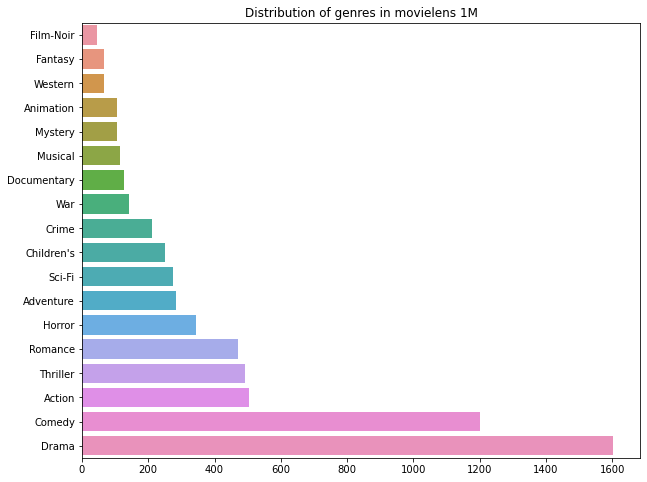

In [39]:
plt.figure(figsize=(10,8))
sns.barplot(x=genre_sum.values, y=genre_sum.index)
plt.title("Distribution of genres in movielens 1M")
plt.show()

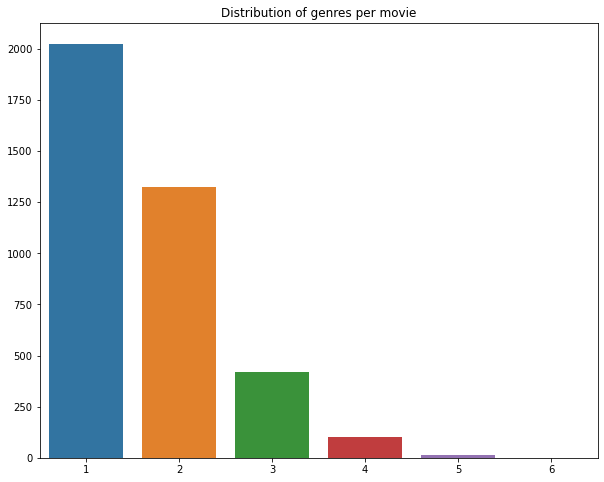

In [45]:
genres_per_item = genre_transform.sum(axis=1).value_counts()
plt.figure(figsize=(10,8))
sns.barplot(x=genres_per_item.index, y=genres_per_item.values)
plt.title("Distribution of genres per movie")
plt.show()

In [28]:
from scipy.sparse import csr_matrix
class BaseEncoder:
    
    def _fit(self, data):
        pass
    
    def fit(self, data, return_type="sparse"):
        array = self._fit(data)
        if return_type == 'sparse':
            return csr_matrix(array)
        elif return_type == 'dataframe':
            cols = self.classes
            idx = self.index
            return pd.DataFrame(array, columns=cols, index=idx)
        else:
            return array
        
    def __call__(self, data, return_type='sparse'):
        return self.fit(data, return_type)

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer
class TfidfEncoder(BaseEncoder):
    
    def __init__(self, **kwargs):
        self.engine = TfidfVectorizer(max_features=100)
        
    def _fit(self, data):
        arr = self.engine.fit_transform(data)
        self.classes = [f"col_{x}" for x in  range(self.engine.max_features)]
        if not hasattr(data, "index"):
            self.index = list(range(len(data)))
        else:
            self.index = data.index.copy()
        return arr

In [31]:
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer

In [32]:
class CategoriEncoder(BaseEncoder):
    
    def __init__(self, **kwargs):
        self.engine = LabelBinarizer()
        
    def _fit(self, data):
        arr = self.engine.fit_transform(data)
        self.classes = self.engine.classes_
        if not hasattr(data, "index"):
            self.index = list(range(len(data)))
        else:
            self.index = data.index.copy()
        return arr
    
class ListEncoder(BaseEncoder):
    
    def __init__(self, **kwargs):
        self.engine = MultiLabelBinarizer()
        
    def _fit(self, data):
        arr = self.engine.fit_transform(data)
        self.classes = self.engine.classes_
        if not hasattr(data, "index"):
            self.index = list(range(len(data)))
        else:
            self.index = data.index.copy()
        return arr

In [114]:
lencoder = ListEncoder()
cencoder = CategoriEncoder()
tencoder = TfidfEncoder()

In [121]:
# lencoder(meta.release_year, return_type='dataframe')

In [115]:
cencoder(meta.release_year.astype(int))

<3883x127 sparse matrix of type '<class 'numpy.intc'>'
	with 3883 stored elements in Compressed Sparse Row format>

In [116]:
tencoder(meta.Title)

<3883x100 sparse matrix of type '<class 'numpy.float64'>'
	with 3847 stored elements in Compressed Sparse Row format>

In [41]:
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
cosine_similarity()

In [33]:
cb_cfg = {
    "id_col": "MovieID",
    "text_cols": ["Title"],
    "categorical_cols": ['release_year'],
    "list_cols": ["Genres"]
}

In [116]:
len([])

0

In [117]:
class ContentBased:
    
    def __init__(self, similarity='cosine'):
        self.similarity = similarity
        self.simi_matrix = np.array([])
        self.categorical_encoder = CategoriEncoder()
        self.text_encoder = TfidfEncoder()
        self.list_encoder = ListEncoder()
        self.item_index_map = {}
        self.item_id = []
        
    @staticmethod
    def cosine_similarity(arr):
        return cosine_similarity(arr)
    
    def recommend(self, iid, k=10):
        
        # Check if model not fitted
        if self.simi_matrix.size == 0:
            raise NotImplementedError(f"Model not fit yet")

        idx = self.item_index_map.get(iid)
        if idx is None:
            return {}
        item_vector = self.simi_matrix[idx]
        top = np.argsort(item_vector)[::-1][:k]
        item_rec = [self.item_id[x] for x in top]
        return (np.array(item_rec), item_vector[top])
        
    def fit(self, data, config):
        self.item_id = data[config['id_col']]
        self.item_index_map = {v:k for k,v in self.item_id.to_dict().items()}
        self.text_features = config['text_cols']
        self.cate_features = config['categorical_cols']
        self.list_features = config['list_cols']
        self.n_feartures = len(self.text_features) + \
                            len(self.cate_features) + \
                            len(self.list_features)
        
        self.simi_matrix = np.zeros((len(data), len(data)))
        
        if self.text_features:
            for cols in self.text_features:
                s_arr = self.cosine_similarity(self.text_encoder(data[cols]))
                self.simi_matrix += s_arr
        if self.cate_features:
            for cols in self.cate_features:
                s_arr = self.cosine_similarity(self.categorical_encoder(data[cols]))
                self.simi_matrix += s_arr
        if self.list_features:
            for cols in self.list_features:
                s_arr = self.cosine_similarity(self.list_encoder(data[cols]))
                self.simi_matrix += s_arr
                
        self.simi_matrix /= self.n_feartures
        print("Done!!!")

In [37]:
data1 = pd.read_json("ml-1m/metadata.json")

In [38]:
data1

,MovieID,Title,Genres,release_year
0,1,Toy Story,"[Animation, Children's, Comedy]",1995
1,2,Jumanji,"[Adventure, Children's, Fantasy]",1995
2,3,Grumpier Old Men,"[Comedy, Romance]",1995
3,4,Waiting to Exhale,"[Comedy, Drama]",1995
4,5,Father of the Bride Part II,[Comedy],1995
...,...,...,...,...
3878,3948,Meet the Parents,[Comedy],2000
3879,3949,Requiem for a Dream,[Drama],2000
3880,3950,Tigerland,[Drama],2000
3881,3951,Two Family House,[Drama],2000


In [113]:
c = ContentBased()

In [114]:
c.fit(data1, cb_cfg)

array([[1.        , 0.44444444, 0.4694161 , ..., 0.        , 0.        ,
        0.        ],
       [0.44444444, 0.66666667, 0.33333333, ..., 0.        , 0.        ,
        0.        ],
       [0.4694161 , 0.33333333, 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.66666667, 0.66666667,
        0.56903559],
       [0.        , 0.        , 0.        , ..., 0.66666667, 1.        ,
        0.56903559],
       [0.        , 0.        , 0.        , ..., 0.56903559, 0.56903559,
        1.        ]])

In [105]:
if c.item_index_map.get(1) is None:
    print("a")

In [78]:
idx = np.where(c.item_id == 1)[0]

In [98]:
np.argsort(c.simi_matrix[0])[::-1][:10]

array([   0,  292, 2205, 3045,  236,  876,   53,  241,   12,   33],
      dtype=int64)

In [115]:
c.recommend(1)

([1, 295, 2274, 3114, 239, 888, 54, 244, 13, 34],
 array([1.        , 0.71846136, 0.66666667, 0.66666667, 0.62200847,
        0.60549886, 0.60549886, 0.60549886, 0.60549886, 0.55555556]))

In [3]:
import pandas as pd
rating = pd.read_csv("data/ratings.dat", delimiter="::", names=['UserID',"MovieID", "Rating", "Timestamp"], engine='python')

In [125]:
rating.MovieID.nunique()

3706

In [12]:
rating['user'] = pd.factorize(rating.UserID)[0]
rating['item'] = pd.factorize(rating.MovieID)[0]

In [139]:
# from sklearn.model_selection import train_test_split
train, test = train_test_split(rating, test_size=0.05, shuffle=True)

In [141]:
test.UserID.isin(train.UserID).shape[0] == test.shape[0]

True

In [140]:
test

,UserID,MovieID,Rating,Timestamp
736027,4401,908,5,965158524
489353,3012,2004,1,998072407
149393,962,2391,3,978233554
547283,3376,2826,2,967587865
896452,5420,1843,3,960156505
...,...,...,...,...
928047,5605,1057,3,959297849
252190,1527,3162,2,974744831
946769,5717,2360,5,958743515
120466,777,1393,2,975441456


In [ ]:
def ensure_test_dataset(test_uid, train_uid):
    return all()

In [142]:
def split_data(data, frac=0.05):
    while 

UserID         6040
MovieID        3516
Rating            5
Timestamp    192582
user           6040
item           3516
dtype: int64

In [1]:
from scipy import sparse
import numpy as np
class Dataset:
    
    def __init__(self, train_df, test_df=None, user='user', item='item', rating='rating', dtype=np.float32):
        self._user = user
        self._item = item
        self._rating = rating
        self.train_df = train_df
        self.test_df = test_df
    
    @property
    def user(self):
        train_user = self.train_df[self._user]
        test_user = self.test_df[self._user]
        return pd.concat([train_user, test_user], ignore_index=True)
    
    @property
    def item(self):
        train_item = self.train_df[self._item]
        test_item = self.test_df[self._item]
        return pd.concat([train_item, test_item], ignore_index=True)
    
    @property
    def rating(self):
        return self.df[self._rating]
    
    def split_data(self):
        pass
        
    def get_factorizer(self, attr='user'):
        if attr not in ['user', 'item']:
            raise ValueError(f"Unknown attribute {attr}, only user, item was accepted")
        data = getattr(self, attr)
        return pd.factorize(data)
    
    def transform_to_matrix(self):
        user, self.user_list = self.get_factorizer("user")
        item, self.item_list = self.get_factorizer('item')
        nuser = len(self.user_list)
        nitem = len(self.item_list)
        return sparse.coo_matrix(
            (self.rating, (user, item)),
            shape=(nuser, nitem)
        )
    
    def get_csr(self):
        return self.transform_to_matrix().tocsr()
    
    def get_csc(self):
        return self.transform_to_matrix().tocsc()
    
    def get_user_history(self, uid):
        res = {"user id": uid}
        history = self.get_csr()
        uidx = np.where(self.user_list == uid)[0][0]
        list_idx_item = history[uidx].indices
        item_id = self.item_list[list_idx_item]
        res['item id watched'] = item_id
        return res
    
    def get_item_history(self, iid):
        res = {"Item id": iid}
        history = self.get_csc()
        iidx = np.where(self.item_list == iid)[0][0]
        list_idx_user = history[:, iidx].indices
        user_id = self.user_list[list_idx_user]
        res['Users has been watch this item'] = user_id
        return res

In [2]:
from models.dataset import Dataset as ds

In [4]:
a = ds(rating, user="UserID", item="MovieID", rating="Rating")

In [5]:
a.get_user_history(1)['item id watched']

Int64Index([1193,  661,  914, 3408, 2355, 1197, 1287, 2804,  594,  919,  595,
             938, 2398, 2918, 1035, 2791, 2687, 2018, 3105, 2797, 2321,  720,
            1270,  527, 2340,   48, 1097, 1721, 1545,  745, 2294, 3186, 1566,
             588, 1907,  783, 1836, 1022, 2762,  150,    1, 1961, 1962, 2692,
             260, 1028, 1029, 1207, 2028,  531, 3114,  608, 1246],
           dtype='int64')

In [17]:
a.get_item_history(0)['Users has been watch this item']

Int64Index([   0,    1,   11,   14,   16,   17,   18,   23,   27,   32,
            ...
            6001, 6010, 6015, 6020, 6031, 6032, 6034, 6035, 6036, 6039],
           dtype='int64', length=1725)

In [19]:
a.get_csc()[:, 0].indices

array([   0,    1,   11, ..., 6035, 6036, 6039])

In [75]:
a.user_list.shape

(1000209,)

In [28]:
nuser = rating.UserID.nunique()
nitem = rating.MovieID.nunique()

In [31]:
matrix = sparse.coo_matrix((rating.Rating, (rating.user, rating.item)), 
                           shape=(nuser, nitem))

In [32]:
matrix

<6040x3706 sparse matrix of type '<class 'numpy.int64'>'
	with 1000209 stored elements in COOrdinate format>

In [18]:
csr_rating = a.get_csr()

In [131]:
csr_rating.indptr

array([      0,      53,     182, ...,  999745,  999868, 1000209],
      dtype=int32)

In [132]:
np.random.choice(csr_rating.indices, size=10)

array([1712, 1098,   18,  177,  237,  218,    8,  556, 1526,  467],
      dtype=int32)

In [6]:
from implicit.als import AlternatingLeastSquares

In [ ]:
class AlternatingLeastSquares1:
    
    def __init__(self, factors=100, num_threads=1, iterations=15):
        self.als = AlternatingLeastSquares(factors=factors, 
                                           num_threads=num_threads, 
                                           iterations=iterations)
        
    
    def fit(self, user_items):
        self.als.fit(user_items)
        
    def 

In [7]:
als = AlternatingLeastSquares(num_threads=1)

In [8]:
import os

In [9]:
os.environ["MKL_NUM_THREADS"] = "1"

In [10]:
als.fit(a.get_csr())

  0%|          | 0/15 [00:00<?, ?it/s]

In [13]:
als.item_factors.shape

(3706, 100)

In [37]:
als.recommend(0, csr_rating[0])

(array([390, 596, 105, 167, 207, 609, 280,  92, 632, 588]),
 array([1.150663  , 0.80094945, 0.7355205 , 0.7318083 , 0.7317914 ,
        0.7206699 , 0.7202057 , 0.7002779 , 0.65813065, 0.65706336],
       dtype=float32))

In [31]:
import pickle

In [32]:
with open("als_model.pkl", "wb") as f:
    pickle.dump(als, f, protocol=pickle.HIGHEST_PROTOCOL)
    f.close()

In [33]:
import implicit

In [34]:
implicit.gpu.HAS_CUDA

False

In [142]:
x1 = np.random.randint(0, 5, size=(5,5))
x2 = np.random.randint(0, 5, size=(4,5))

In [154]:
x3 = np.random.randint(0, 5, size=(2,3))

In [156]:
x3

array([[2, 3, 1],
       [0, 2, 1]])

In [159]:
np.take(x1, x3)

array([[0, 4, 1],
       [2, 0, 1]])

In [148]:
x1

array([[2, 1, 0, 4, 1],
       [2, 2, 0, 0, 4],
       [3, 3, 4, 2, 2],
       [4, 2, 3, 4, 0],
       [0, 2, 1, 2, 1]])

In [151]:
from sklearn.metrics import mean_squared_error

In [154]:
mean_squared_error(x1[:4], x2)

2.95

In [164]:
yhat = np.round(als.user_factors.dot(als.item_factors.T), 2)

In [166]:
mean_squared_error(yhat, csr_rating.toarray())

0.43916639168422966

In [168]:
def evaluate(model, test):
    

array([[5, 3, 3, ..., 0, 0, 0]], dtype=int64)

In [18]:
df = pd.read_csv("./data/rating.csv", index_col=0)

In [19]:
df

,UserID,MovieID,Rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5
...,...,...,...
1000204,6040,1091,1
1000205,6040,1094,5
1000206,6040,562,5
1000207,6040,1096,4
